# Transformer Model.

Automated Customer Review Analysis and Visualization using Transformer Models.



*   Automated processing of customer reviews using machine learning and natural language processing techniques.

*   Leveraging Transformer-based models (such as those available in the Hugging Face API) for both classification and summarization of the reviews.
*   Developing a dynamic visualization dashboard to provide insights into the customer sentiment and review summaries.


#### Table of Contents

- [1 - Base Model](#1)
 - [1.1 - Set up, data pre-processing](#1.1)
 - [2.2 - Base model Training](#1.2)
- [2 - Fine-Tuning](#2)
 - [2.1 - Data pre-processing](#2.1)
 - [2.2 - Model training setup and evaluation](#2.2)
 - [2.3 - Model visualization](#2.3)
- [3 - Model saving](#3)

<a name='1'></a>
#### Base Model

<a name='1.1'></a>
##### 1 - Set up, data pre-processing

In [ ]:
# Necessary installation.
!pip install transformers~=4.31.0
!pip install accelerate~=0.21.0
!pip install datasets==2.10.1
!pip install pyarrow==10.0.1
!pip install torch


In [ ]:
# Set API key for Hugging Face.
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')


google-bert/bert-base-uncased  [https://huggingface.co/google-bert/bert-base-uncased](https://)

In [ ]:
# Import essential libraries.
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Imports the BertTokenizer and BertModel classes.
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
foundation_model = BertModel.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive') # load data from the cloud.
df = pd.read_csv('/content/drive/MyDrive/1429_1.csv')

print(df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(34660, 21)


<ipython-input-4-dccd0e8209fc>:4: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/1429_1.csv')


In [ ]:
import re

# Set the chunk size.
chunk_size = 10000

# Create a stream reader.
stream_reader = pd.read_csv('/content/drive/MyDrive/1429_1.csv', chunksize=chunk_size)

# Iterate over the chunks and clean the review text.
for chunk in stream_reader:
    # Clean the review text.
    chunk['reviews.text'] = chunk['reviews.text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
    chunk['reviews.text'] = chunk['reviews.text'].str.strip()

    # Check the cleaned text.
    if not chunk['reviews.text'].empty:
        print(chunk['reviews.text'].sample(5))
    else:
        print("The 'reviews.text' column is empty.")

9929    The product is good and easy to operate I guar...
8721    I purchased this item for my nephew and he lov...
532     Not to much to complain about for less than 10...
4333    excellent value for the price Tablet works wel...
5149    Nit sure was s gift not sure what the product ...
Name: reviews.text, dtype: object
19440    I like it small lightweight easy to see wifi c...
10233    Purchased the Kindle fire fir my grandfaughter...
16701    Kids love it Easy for them to use Only issue i...
18532    Must have if you like to read on a tablet Easy...
15054       Faster and good quality for this kind of brand
Name: reviews.text, dtype: object
28834    Ive had my kindle fire 70 for more than 3 year...
22998    Its going to take more work to get her up to u...
29177    I liked it as it was a great price and the siz...
28469    Just as expectedThe Amazon Echo performs great...
21773    My grandson loved it He plays it everyday Papa...
Name: reviews.text, dtype: object
32440    Very happ

In [ ]:
# Select relevant columns.
df = df[['reviews.text', 'reviews.rating']]

# Drop missing values.
df = df.dropna(subset=['reviews.text'])

# Ensure all texts are strings.
df['reviews.text'] = df['reviews.text'].astype(str)

# Map ratings to sentiment classes.
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets.
X = df['reviews.text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set shape: X_train: (27727,), y_train: (27727,)
Testing set shape: X_test: (6932,), y_test: (6932,)


In [ ]:
# Tokenize the text.
def tokenize_texts(texts, tokenizer, max_length=512):
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True
    )

# Tokenize the training and testing sets.
train_encodings = tokenize_texts(X_train, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)


In [ ]:
# Convert labels to numerical format.
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# Convert labels to torch tensors.
y_train_tensor = torch.tensor(y_train_encoded)
y_test_tensor = torch.tensor(y_test_encoded)

print("Training set encodings:", train_encodings)
print("Testing set encodings:", test_encodings)
print("Training labels:", y_train_tensor)
print("Testing labels:", y_test_tensor)


Training set encodings: {'input_ids': tensor([[  101,  1045,  2941,  ...,     0,     0,     0],
        [  101,  2145,  4083,  ...,     0,     0,     0],
        [  101,  1045,  4149,  ...,     0,     0,     0],
        ...,
        [  101,  2023,  2003,  ...,     0,     0,     0],
        [  101,  1045,  7007,  ...,     0,     0,     0],
        [  101,  2023, 13855,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
Testing set encodings: {'input_ids': tensor([[  101, 12476,  4031,  ...,     0,     0,     0],
        [  101,  1045,  2293, 

In [ ]:
from tqdm import tqdm
# Function to get BERT embeddings.
def get_bert_embeddings(text_list, model, tokenizer, max_length=512):
    embeddings = []
    for text in tqdm(text_list, desc="Encoding texts"):
        encoded_input = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
        with torch.no_grad():
            model_output = model(**encoded_input)
        embeddings.append(model_output.last_hidden_state[:, 0, :].squeeze().numpy()) # using CLS token embedding.
    return embeddings

# Get BERT embeddings for train and test sets.
X_train_embeddings = get_bert_embeddings(X_train.tolist(), foundation_model, tokenizer)
X_test_embeddings = get_bert_embeddings(X_test.tolist(), foundation_model, tokenizer)


Encoding texts: 100%|██████████| 6932/6932 [34:38<00:00,  3.33it/s]


<a name='1.2'></a>
##### 1.2 - Base model Training

In [ ]:
# Train a simple classifier.
classifier = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
classifier.fit(X_train_embeddings, y_train_encoded)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
# Evaluate the classifier.
y_pred = classifier.predict(X_test_embeddings)
accuracy = accuracy_score(y_test_encoded, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", report)


Accuracy: 0.9311886901327179
Precision: 0.9156949443893885
Recall: 0.9311886901327179
F1 Score: 0.9210896626036491

Classification Report:
               precision    recall  f1-score   support

    negative       0.43      0.40      0.41       165
     neutral       0.40      0.17      0.24       321
    positive       0.95      0.98      0.97      6446

    accuracy                           0.93      6932
   macro avg       0.59      0.52      0.54      6932
weighted avg       0.92      0.93      0.92      6932



<a name='2'></a>
#### 2 - Fine-Tuning

<a name='2.1'></a>
##### 2.1 - Data pre-processing

In [ ]:
from datasets import Dataset
# Create a Dataset for the training and test data.
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train_encoded}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test_encoded}))


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to tokenize.
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)
# Apply the tokenize_function to the training and test dataset.
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
# Set the format of the training and test dataset to PyTorch tensors.
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/27727 [00:00<?, ? examples/s]

Map:   0%|          | 0/6932 [00:00<?, ? examples/s]

<a name='2.2'></a>
##### 2.2 - Model training setup and evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load a pre-trained BERT model for sequence classification with 3 output labels.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Define the training arguments for the Trainer.
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    tpu_num_cores=8
)


# Define a function to compute metrics for evaluation.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model.
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.118400,0.228951,0.930612,0.919240,0.918105,0.930612
2,0.358700,0.245997,0.932631,0.925117,0.921651,0.932631
3,0.189400,0.264908,0.934362,0.930449,0.927783,0.934362


TrainOutput(global_step=10398, training_loss=0.2015232104307589, metrics={'train_runtime': 2320.3773, 'train_samples_per_second': 35.848, 'train_steps_per_second': 4.481, 'total_flos': 2.188603720003277e+16, 'train_loss': 0.2015232104307589, 'epoch': 3.0})

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate the model.
eval_results = trainer.evaluate()
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Print evaluation results and classification report.
print("Evaluation Results:", eval_results)
report = classification_report(labels, preds, target_names=label_encoder.classes_)
print("\nClassification Report:\n", report)


Evaluation Results: {'eval_loss': 0.2649082541465759, 'eval_accuracy': 0.9343623773802654, 'eval_f1': 0.9304493829598108, 'eval_precision': 0.9277828905431277, 'eval_recall': 0.9343623773802654, 'eval_runtime': 53.125, 'eval_samples_per_second': 130.485, 'eval_steps_per_second': 16.32, 'epoch': 3.0}

Classification Report:
               precision    recall  f1-score   support

    negative       0.64      0.43      0.51       165
     neutral       0.34      0.29      0.31       321
    positive       0.96      0.98      0.97      6446

    accuracy                           0.93      6932
   macro avg       0.65      0.57      0.60      6932
weighted avg       0.93      0.93      0.93      6932



<a name='2.3'></a>
##### 2.3 - Model visualization

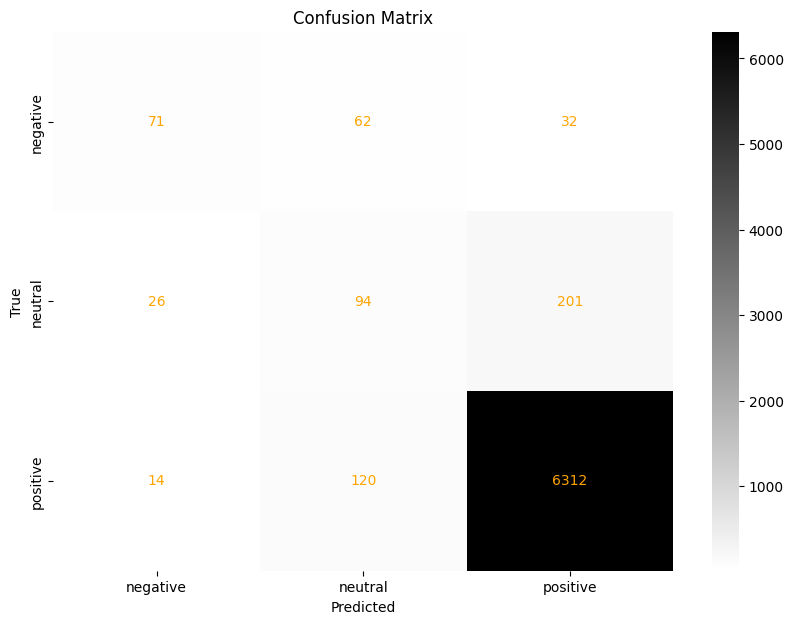

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix.
conf_matrix = confusion_matrix(labels, preds)

# Plot confusion matrix.
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='binary',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    annot_kws={"color": "orange"}
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


<a name='3'></a>
#### 3 - Model saving

In [ ]:
# Save the model.
model.save_pretrained('/content/drive/MyDrive/fine_tuned_model')

# Save the tokenizer.
tokenizer.save_pretrained('/content/drive/MyDrive/fine_tuned_tokenizer')


('/content/drive/MyDrive/fine_tuned_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/fine_tuned_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/fine_tuned_tokenizer/vocab.txt',
 '/content/drive/MyDrive/fine_tuned_tokenizer/added_tokens.json')